In [59]:
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

# Http Dataset

In [61]:
df = pd.read_csv('/Users/zhansaya/Downloads/dataset_https.csv', comment='#')

In [62]:
print(df.shape)

(65534, 5)


In [63]:
df.head()

,index,feature 1,feature 2,feature 3,label
0,0,0,181,5450,0
1,0,0,239,486,0
2,0,0,235,1337,0
3,0,0,219,1337,0
4,0,0,217,2032,0


In [64]:
df=df.astype(float)

In [65]:
df.dtypes

index        float64
feature 1    float64
feature 2    float64
feature 3    float64
label        float64
dtype: object

In [66]:
stream = DataStream(df)

In [67]:
stream.prepare_for_use()

print(f'n_remaining_samples: {stream.n_remaining_samples()}')
print(f'feature_names: {stream.feature_names}')
print(f'target_names: {stream.target_names}')

n_remaining_samples: 65534
feature_names: ['index', 'feature 1', 'feature 2', 'feature 3']
target_names: ['label']


In [68]:
# define anomaly detection learner
learner = HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=100, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5
)

# lists to collect data into
X_vals = []
y_preds = []
y_probs = []

In [69]:
# some params
n = 0
n_burn_in = 500

In [70]:
# process the stream data
while stream.has_more_samples():
    X, y = stream.next_sample()
    # wait until enough burn in data processed
    if n > n_burn_in:
        y_pred = learner.predict(X).tolist()
        y_prob = learner.predict_proba(X).tolist()[0]
        X_vals.append(X.tolist()[0])
        y_preds.append(y_pred)
        y_probs.append(y_prob)
    learner.partial_fit(X, y)
    n += 1

0.0

In [71]:
# put results into a df
df_x = pd.DataFrame(X_vals,columns=stream.feature_names)
df_probs = pd.DataFrame(y_probs,columns=[f'prob_{n}' for n in range(len(y_probs[0]))])
df_preds = pd.DataFrame(y_preds,columns=[f'pred_{n}' for n in range(len(y_preds[0]))])
df = pd.concat([df_x,df_probs,df_preds],axis=1)
print(df.shape)
df.head()


(65033, 7)


,index,feature 1,feature 2,feature 3,prob_0,prob_1,pred_0
0,0.0,0.0,268.0,602.0,1.0,0.0,0
1,0.0,0.0,173.0,4522.0,1.0,0.0,0
2,0.0,0.0,228.0,1192.0,1.0,0.0,0
3,0.0,0.0,231.0,36340.0,1.0,0.0,0
4,0.0,0.0,241.0,1884.0,1.0,0.0,0


In [78]:
def evaluation(stream,learner,wait_samples,max_samples):
    cnt = 0
    y_pred = []
    y_proba = []
    y_result = []
    kappa = []
    AUC = []
    score = 0
    classes = 0
    
    stream.prepare_for_use()

    while cnt < max_samples:
        X, y = stream.next_sample()
        # Scale inputs between 0 and 1
        X = X / 10
        if (cnt % wait_samples == 0) and (cnt != 0):
            if y[0] not in y_result:
                classes+=1
            y_pred.append(learner.predict(X)[0])
            y_proba.append(learner.predict_proba(X)[0])
            y_result.append(y[0])
            if y==learner.predict(X):
                score +=1
            if cnt!=wait_samples:
                kappa.append(cohen_kappa_score(y_pred,y_result))
                if classes>1:
                  AUC.append(roc_auc_score(y_result,y_pred))
            print("Data: ",X)
            print("Predict: ",y,"->",learner.predict(X))
            print("Predict Proba: ",learner.predict_proba(X))
        learner.partial_fit(X, y)

        cnt += 1
    print("Label prediction: \n",y_pred)
    print("True Label : \n",y_result)
    score = score/((max_samples/wait_samples)-1)
    print("Score: ",score)
    print("Kappa score: ",kappa[-1])
    print("AUC score: ",AUC[-1])
    plt.subplot(211)
    plt.plot(kappa)
    plt.title("Kappa Score")
    plt.subplot(212)
    plt.plot(AUC)
    plt.title("AUC Score")
    plt.show()
    #Time and Memory
    #Use Evaluator

In [79]:
evaluation(stream,learner,50,1000)

Data:  [[   0.     0.    30.  4274.7]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.8236 0.1764]]
Data:  [[ 0.   0.  31.4 30.8]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.9434 0.0566]]
Data:  [[  0.    0.   32.4 187.5]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.9434 0.0566]]
Data:  [[  0.    0.   21.6 164.5]]
Predict:  [0.] -> [0]
Predict Proba:  [[1. 0.]]
Data:  [[   0.     0.    24.6 1188.9]]
Predict:  [0.] -> [0]
Predict Proba:  [[1. 0.]]
Data:  [[  0.    0.   24.  815.9]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.9 0.1]]
Data:  [[  0.    0.   30.8 234.5]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.9 0.1]]
Data:  [[ 0.   0.  28.1 75.7]]
Predict:  [0.] -> [0]
Predict Proba:  [[1. 0.]]
Data:  [[ 0.   0.  30.7 89.1]]
Predict:  [0.] -> [0]
Predict Proba:  [[1. 0.]]
Data:  [[ 0.   0.  31.4 56.9]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.9902 0.0098]]
Data:  [[ 0.   0.  21.1 31.3]]
Predict:  [0.] -> [0]
Predict Proba:  [[0.9902 0.0098]]
Data:  [[ 0.   0.  21.7 65.4]]
Predict:  [0.] -> [0]
Pr

IndexError: list index out of range

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #------------------- [5%] [10.41s]

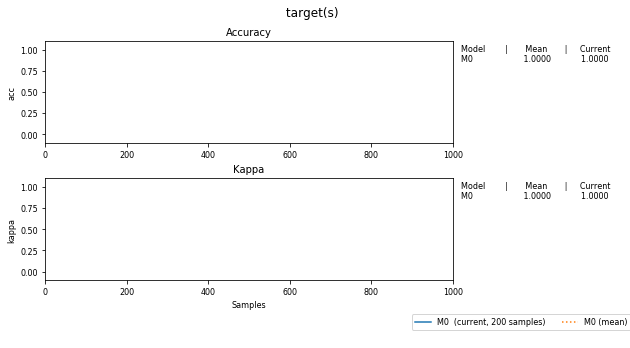

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##------------------ [10%] [22.29s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###----------------- [15%] [34.38s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ####---------------- [20%] [46.10s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #####--------------- [25%] [58.21s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ######-------------- [30%] [70.23s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #######------------- [35%] [82.88s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ########------------ [40%] [95.20s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #########----------- [45%] [108.20s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##########---------- [50%] [121.46s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###########--------- [55%] [136.37s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ############-------- [60%] [149.67s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #############------- [65%] [163.49s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##############------ [70%] [177.72s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###############----- [75%] [191.40s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ################---- [80%] [204.48s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #################--- [85%] [217.16s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##################-- [90%] [231.17s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###################- [95%] [244.25s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #################### [100%] [258.74s]


<Figure size 432x288 with 0 Axes>

Processed samples: 20000
Mean performance:
M0 - Accuracy     : 0.7808
M0 - Kappa        : 0.0035


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, n_features=4,
                random_state=5, size_limit=10.0, window_size=100)]

In [82]:
evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=20000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=learner)

In [73]:
for p in [col for col in df.columns if 'prob' in col]:
    df[f"smooth_p{p.split('_')[-1]}"] = df[p].rolling(10).mean()

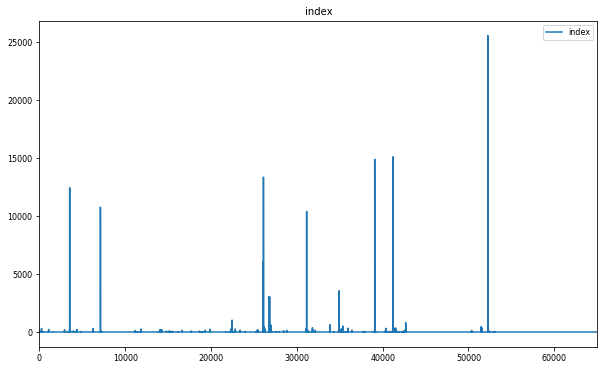

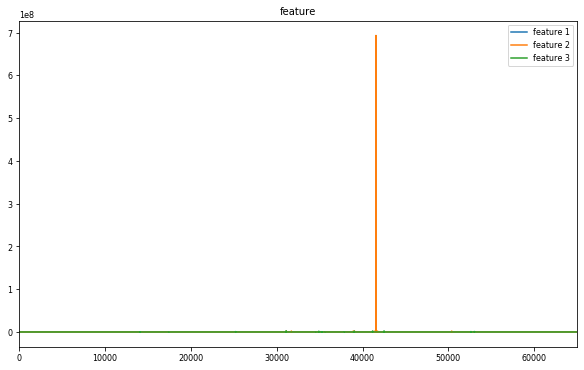

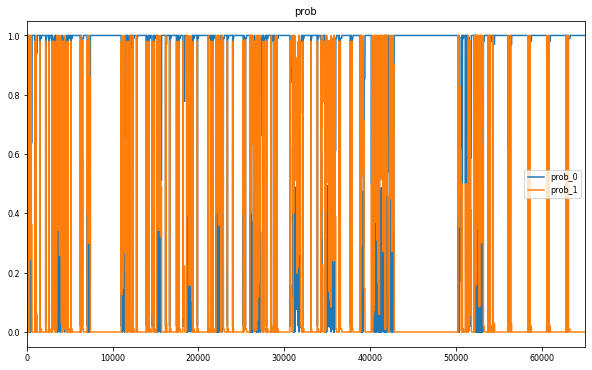

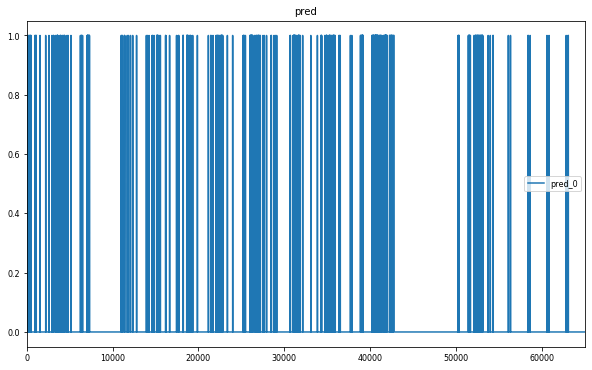

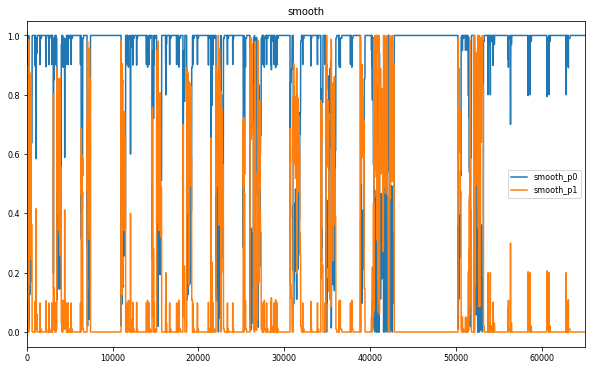

In [81]:
# plot the cols, probs and preds
for prefix in ['index','feature','prob','pred','smooth']:
    plot_cols = [col for col in df.columns if prefix in col]
    df[plot_cols].plot(title=prefix, figsize=(10,6))

# Covertype dataset

In [71]:
df = pd.read_csv('/Users/zhansaya/Downloads/train-set.csv', comment='#')

In [72]:
print(df.shape)

(528720, 56)


In [73]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2611,326,20,120,27,1597,168,214,184,2913,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
1,2,2772,324,17,42,7,1814,175,220,183,2879,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,3,2764,4,14,480,-21,700,201,212,148,700,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,3032,342,9,60,8,4050,202,227,164,2376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,5,2488,23,11,117,21,1117,209,218,151,1136,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [75]:
stream = DataStream(df)

In [76]:
stream.prepare_for_use()

print(f'n_remaining_samples: {stream.n_remaining_samples()}')
print(f'feature_names: {stream.feature_names}')
print(f'target_names: {stream.target_names}')

n_remaining_samples: 528720
feature_names: ['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
target_names: ['Cover_Type']


In [77]:
# define anomaly detection learner
learner = HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=100, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5
)

# lists to collect data into
X_vals = []
y_preds = []
y_probs = []

In [78]:
# some params
n = 0
n_burn_in = 500

In [79]:
# process the stream data
while stream.has_more_samples():
    X, y = stream.next_sample()
    # wait until enough burn in data processed
    if n > n_burn_in:
        y_pred = learner.predict(X).tolist()
        y_prob = learner.predict_proba(X).tolist()[0]
        X_vals.append(X.tolist()[0])
        y_preds.append(y_pred)
        y_probs.append(y_prob)
    learner.partial_fit(X, y)
    n += 1

KeyboardInterrupt: 

In [ ]:
# put results into a df
df_x = pd.DataFrame(X_vals,columns=stream.feature_names)
df_probs = pd.DataFrame(y_probs,columns=[f'prob_{n}' for n in range(len(y_probs[0]))])
df_preds = pd.DataFrame(y_preds,columns=[f'pred_{n}' for n in range(len(y_preds[0]))])
df = pd.concat([df_x,df_probs,df_preds],axis=1)
print(df.shape)
df.head()

In [ ]:
# smooth out probs
for p in [col for col in df.columns if 'prob' in col]:
    df[f"smooth_p{p.split('_')[-1]}"] = df[p].rolling(10).mean()

In [ ]:
# plot the cols, probs and preds
for prefix in ['col','prob','pred','smooth']:
    plot_cols = [col for col in df.columns if prefix in col]
    df[plot_cols].plot(title=prefix, figsize=(10,6))